In [3]:
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from cfe_py.bmi_cfe import BMI_CFE
import os
from cfe_py.fao_pet import FAO_PET

# Read CAMELS data

In [4]:
data_dir = "G:\Shared drives\SI_NextGen_Aridity\dCFE\data"
basin_id = "06332515" #01031500 # 01022500 # 01137500 # 02350900 # 05507600 # 11476600 # 14301000 # 07261000 # 06332515
start_time = '2000-10-01 00:00:00'
end_time = '2010-09-30 23:00:00'

In [5]:
filename = f"{basin_id}_hourly_nldas.csv"
_forcing_df = pd.read_csv(os.path.join(data_dir, filename))
_forcing_df.set_index(pd.to_datetime(_forcing_df["date"]), inplace=True)
forcing_df = _forcing_df[start_time:end_time].copy()
forcing_df.head()

# # Convert pandas dataframe to PyTorch tensors
# Convert units
# (precip/1000)   # kg/m2/h = mm/h -> m/h
# (pet/1000/3600) # kg/m2/h = mm/h -> m/s
conversions_m_to_mm = 1000
precip =  forcing_df["total_precipitation"].values / conversions_m_to_mm

pet = FAO_PET(nldas_forcing=forcing_df, basin_id=basin_id).calc_PET().values

In [6]:
filename = f"{basin_id}-usgs-hourly.csv"
obs_q_ = pd.read_csv(os.path.join(data_dir, filename))
obs_q_.set_index(pd.to_datetime(obs_q_["date"]), inplace=True)
# obs_q_ = obs_q_["QObs(mm/h)"].values / conversions_m_to_mm
q = obs_q_[start_time:end_time].copy()
q = q["QObs(mm/h)"] / conversions_m_to_mm

# Read default DDS params

In [7]:
filename = f"cat_{basin_id}_bmi_config_cfe.json"
with open(os.path.join(data_dir,filename), 'r') as file:
    cfe_params = json.load(file)
cfe_params

{'soil_params': {'depth': 2.0,
  'bb': 6.363636363636363,
  'satdk': 3.6158636363636365e-06,
  'satpsi': 0.3270466444545455,
  'slop': 0.03366393650000001,
  'smcmax': 0.5149321769999999,
  'wltsmc': 0.08321613636363637,
  'D': 2.0,
  'mult': 1000.0},
 'forcing_file': '..\\data\\camels\\gauch_etal_2020\\nldas_hourly\\06332515_hourly_nldas.csv',
 'catchment_area_km2': 191.49,
 'refkdt': 2.7812260990454547,
 'max_gw_storage': 0.012271355629,
 'Cgw': 1.8e-05,
 'expon': 7.0,
 'gw_storage': 0.05,
 'alpha_fc': 0.33,
 'K_nash': 0.03,
 'K_lf': 0.01,
 'nash_storage': [0.0, 0.0],
 'giuh_ordinates': [0.45, 0.31, 0.15, 0.06, 0.02, 0.01, 0.0, 0.0],
 'stand_alone': 1,
 'unit_test': 0,
 'compare_results_file': '',
 'partition_scheme': 'Schaake',
 'soil_scheme': 'classic'}

# Read DDS best params

In [14]:
dds_dir = r"G:\Shared drives\Ryoko and Hilary\cfe_py_camels\dds\results\result-2023-11-29"
filename = f"{basin_id}_bestparams.csv"
with open(os.path.join(dds_dir,filename), 'r') as file:
    dds_params = json.load(file)
dds_params

{'best parameters': {'bb': 10.992011518955469,
  'satdk': 0.0006633039779514547,
  'slop': 0.6591061088951465,
  'smcmax': 0.7200195402756007,
  'max_gw_storage': 0.06184765011166878,
  'Cgw': 2.68e-06,
  'K_lf': 0.5043536859297311,
  'K_nash': 0.7844011181932413,
  'expon': 1.7347788798321637},
 'best objective values': [-0.04741547228590992]}

In [15]:
# List of parameters to be updated in cfe_params
param_keys = ['bb', 'smcmax', 'satdk', 'slop', 'max_gw_storage', 'expon', 'Cgw', 'K_lf', 'K_nash']

# Looping through each key and updating cfe_params from dds_params
for key in param_keys:
    if key in cfe_params['soil_params']:
        cfe_params['soil_params'][key] = dds_params['best parameters'][key]
    else:
        cfe_params[key] = dds_params['best parameters'][key]

# if dds_params['best parameters']['scheme'] <= 0.5:
#     cfe_params['partition_scheme'] = "Schaake"
# else:
#     cfe_params['partition_scheme'] = "Xinanjiang"

In [16]:
# File path for the new JSON file
output_file_name = f"cat_{basin_id}_dds_calibrated.json"

# Saving the updated dictionary to a JSON file
with open(os.path.join(data_dir, output_file_name), 'w') as file:
    json.dump(cfe_params, file, indent=4)

# Run CFE simulations

In [18]:
partitioning_scheme = cfe_params['partition_scheme']
soil_scheme = "classic"
cfe_instance = BMI_CFE(cfg_file=os.path.join(data_dir, output_file_name), soil_scheme=soil_scheme, partitioning_scheme=partitioning_scheme)
cfe_instance.stand_alone = 0
synthetic_Cgw = dds_params['best parameters']['Cgw']
synthetic_satdk = dds_params['best parameters']['satdk']
cfe_instance.initialize(Cgw=synthetic_Cgw, satdk=synthetic_satdk)

In [19]:
outputs = cfe_instance.get_output_var_names()
output_lists = {output:[] for output in outputs}

for precip_t, pet_t in zip(precip, pet):
    
    cfe_instance.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip_t)
    cfe_instance.set_value("water_potential_evaporation_flux", pet_t)
    
    cfe_instance.update()
    
    for output in outputs:
        output_lists[output].append(cfe_instance.get_value(output))
cfe_instance.finalize(print_mass_balance=True)


GLOBAL MASS BALANCE
  initial volume:   0.9914
    volume input:   3.6718
   volume output:   4.2468
    final volume:   0.4164
        residual: -1.3989e-13

PARTITION MASS BALANCE
    surface runoff:   0.0096
      infiltration:   3.1068
 vol. et from rain:   0.5554
partition residual: -4.3299e-15

GIUH MASS BALANCE
  vol. into giuh:   0.0096
   vol. out giuh:   0.0096
 vol. end giuh q:   0.0000
   giuh residual: -2.6021e-17

SOIL WATER CONCEPTUAL RESERVOIR MASS BALANCE
     init soil vol:   0.9605
    vol. into soil:   3.1068
  vol.soil2latflow:   0.0000
   vol. soil to gw:   0.0000
 vol. et from soil:   3.6509
   final vol. soil:   0.4164
  vol. soil resid.: 1.6709e-14

NASH CASCADE CONCEPTUAL RESERVOIR MASS BALANCE
    vol. to nash:   0.0000
  vol. from nash:   0.0000
 final vol. nash:   0.0000
nash casc resid.: 0.0000e+00

GROUNDWATER CONCEPTUAL RESERVOIR MASS BALANCE
init gw. storage:   0.0309
       vol to gw:   0.0000
     vol from gw:   0.0309
final gw.storage:   0.0000
    

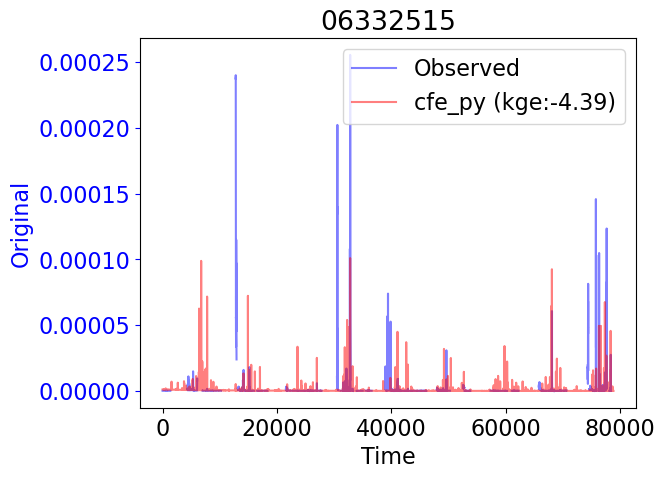

In [22]:
import hydroeval as he
warmup = 24 * 365
fig, ax1 = plt.subplots()
original_data = np.array(output_lists["land_surface_water__runoff_depth"])
x = q.values[warmup:]
y = original_data[warmup:]

# nse = he.nse(x[~np.isnan(x)], y[~np.isnan(x)])
kge = he.kge(x[~np.isnan(x)], y[~np.isnan(x)])
ax1.plot(q.values[warmup:], 'b-', label=f"Observed", alpha=0.5)
ax1.plot(original_data[warmup:], 'r-', label=f"cfe_py (kge:{kge[0][0]:.2f})", alpha=0.5)
ax1.set_xlabel('Time')
ax1.set_ylabel(f"Original", color='b')
ax1.tick_params('y', colors='b')
ax1.set_title(basin_id)
ax1.legend()

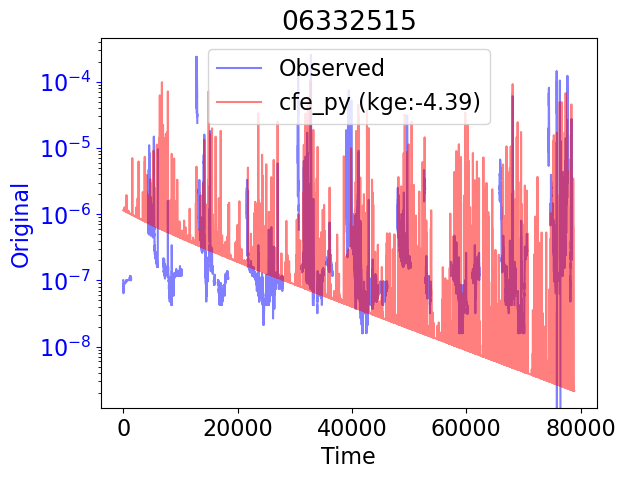

In [21]:
fig, ax1 = plt.subplots()
original_data = output_lists["land_surface_water__runoff_depth"]
ax1.plot(q.values[warmup:], 'b-', label=f"Observed", alpha=0.5)
ax1.plot(original_data[warmup:], 'r-', label=f"cfe_py (kge:{kge[0][0]:.2f})", alpha=0.5)
ax1.set_xlabel('Time')
ax1.set_ylabel(f"Original", color='b')
ax1.tick_params('y', colors='b')
ax1.set_yscale('log')
ax1.set_title(basin_id)
ax1.legend()